<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Q-value-learning" data-toc-modified-id="Q-value-learning-1">Q value learning</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Comparing-environment-interfaces" data-toc-modified-id="Comparing-environment-interfaces-1.3">Comparing environment interfaces</a></span><ul class="toc-item"><li><span><a href="#Open-AI-Gym" data-toc-modified-id="Open-AI-Gym-1.3.1">Open AI Gym</a></span></li><li><span><a href="#Step" data-toc-modified-id="Step-1.3.2">Step</a></span></li><li><span><a href="#Decision" data-toc-modified-id="Decision-1.3.3">Decision</a></span></li></ul></li><li><span><a href="#Verifying-the-information-received-by-the-agent" data-toc-modified-id="Verifying-the-information-received-by-the-agent-1.4">Verifying the information received by the agent</a></span></li><li><span><a href="#Implementing-the-GameState" data-toc-modified-id="Implementing-the-GameState-1.5">Implementing the GameState</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-1.6">Model</a></span></li><li><span><a href="#Agent" data-toc-modified-id="Agent-1.7">Agent</a></span></li><li><span><a href="#Model-for-training" data-toc-modified-id="Model-for-training-1.8">Model for training</a></span></li><li><span><a href="#Prepare-data-for-training" data-toc-modified-id="Prepare-data-for-training-1.9">Prepare data for training</a></span></li><li><span><a href="#Simmetry-on-the-data" data-toc-modified-id="Simmetry-on-the-data-1.10">Simmetry on the data</a></span><ul class="toc-item"><li><span><a href="#Vertical-and-horizontal-simmetry" data-toc-modified-id="Vertical-and-horizontal-simmetry-1.10.1">Vertical and horizontal simmetry</a></span></li><li><span><a href="#Player-simmetry" data-toc-modified-id="Player-simmetry-1.10.2">Player simmetry</a></span></li><li><span><a href="#Apply-all-simmetries" data-toc-modified-id="Apply-all-simmetries-1.10.3">Apply all simmetries</a></span></li></ul></li><li><span><a href="#First-training" data-toc-modified-id="First-training-1.11">First training</a></span></li><li><span><a href="#More-information-and-more-tests" data-toc-modified-id="More-information-and-more-tests-1.12">More information and more tests</a></span></li><li><span><a href="#Test-for-independent-execution-of-scripts" data-toc-modified-id="Test-for-independent-execution-of-scripts-1.13">Test for independent execution of scripts</a></span></li><li><span><a href="#Evaluate-models" data-toc-modified-id="Evaluate-models-1.14">Evaluate models</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.14.1">Data</a></span></li><li><span><a href="#Play-games" data-toc-modified-id="Play-games-1.14.2">Play games</a></span></li><li><span><a href="#Compute-Elo-score" data-toc-modified-id="Compute-Elo-score-1.14.3">Compute Elo score</a></span></li></ul></li><li><span><a href="#Visualizing-some-games" data-toc-modified-id="Visualizing-some-games-1.15">Visualizing some games</a></span></li><li><span><a href="#Idea-to-speedup-training" data-toc-modified-id="Idea-to-speedup-training-1.16">Idea to speedup training</a></span></li><li><span><a href="#TODO" data-toc-modified-id="TODO-1.17">TODO</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.18">Summary</a></span></li></ul></li></ul></div>

# Q value learning

## Goal

On this notebook I will try to implement the first training of a model that uses Q value learning.

## Imports

In [1]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

In [25]:
import os
import kaggle_environments
from kaggle_environments import make
from kaggle_environments import evaluate
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
from tqdm.notebook import tqdm
import time
from itertools import permutations
from functools import partial

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import tensorflow.keras as keras

from hungry_geese import GameState
from hungry_geese.state import make_board_egocentric, get_head_position
from hungry_geese.utils import ACTIONS, opposite_action, get_timestamp
from hungry_geese.definitions import ACTION_TO_IDX
from hungry_geese.agents import EpsilonAgent
from hungry_geese.evaluation import play_matches_in_parallel
from hungry_geese.elo import EloRanking

%config Completer.use_jedi = False

In [20]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Comparing environment interfaces

### Open AI Gym

https://github.com/Kaggle/kaggle-environments#training

In [4]:
env = make('hungry_geese')
trainer = env.train([None, "greedy", "greedy", "greedy"])

In [11]:
obs = trainer.reset()
obs

{'remainingOverageTime': 60,
 'step': 0,
 'geese': [[17], [46], [0], [23]],
 'food': [51, 34],
 'index': 0}

In [13]:
trainer.step('NORTH')

[{'remainingOverageTime': 60,
  'step': 1,
  'geese': [[6], [35], [1], [34, 23]],
  'food': [51, 25],
  'index': 0},
 201,
 False,
 {}]

In [14]:
trainer.step('NORTH')

[{'remainingOverageTime': 60,
  'step': 2,
  'geese': [[72], [24], [2], [45, 34]],
  'food': [51, 25],
  'index': 0},
 100,
 False,
 {}]

In [15]:
trainer.step('NORTH')

[{'remainingOverageTime': 60,
  'step': 3,
  'geese': [[61], [25, 24], [3], [46, 45]],
  'food': [51, 2],
  'index': 0},
 100,
 False,
 {}]

In [16]:
trainer.step('NORTH')

[{'remainingOverageTime': 60,
  'step': 4,
  'geese': [[50], [26, 25], [4], [35, 46]],
  'food': [51, 2],
  'index': 0},
 100,
 False,
 {}]

In [17]:
trainer.step('WEST')

[{'remainingOverageTime': 60,
  'step': 5,
  'geese': [[49], [27, 26], [5], [24, 35]],
  'food': [51, 2],
  'index': 0},
 100,
 False,
 {}]

In [18]:
trainer.step('EAST')

[{'remainingOverageTime': 60,
  'step': 6,
  'geese': [[], [28, 27], [71], [13, 24]],
  'food': [51, 2],
  'index': 0},
 0,
 True,
 {}]

So it seems we could use this implementation for training. The advantage is that we just have to care about our agent, not about the others.

In [19]:
env.configuration

{'episodeSteps': 200,
 'actTimeout': 1,
 'runTimeout': 1200,
 'columns': 11,
 'rows': 7,
 'hunger_rate': 40,
 'min_food': 2,
 'max_length': 99}

### Step

https://github.com/Kaggle/kaggle-environments#stepping

In [20]:
env = make('hungry_geese')

In [22]:
env.reset(num_agents=4)

[{'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 0,
   'geese': [[22], [73], [20], [65]],
   'food': [58, 37],
   'index': 0},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 1},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 2},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 3},
  'status': 'ACTIVE'}]

In [23]:
env.state

[{'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 0,
   'geese': [[22], [73], [20], [65]],
   'food': [58, 37],
   'index': 0},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 1},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 2},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 3},
  'status': 'ACTIVE'}]

I see a problem here, only the first state has information about the geese.

In [25]:
env.step(['NORTH', 'NORTH', 'NORTH', 'NORTH'])

[{'action': 'NORTH',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 1,
   'geese': [[11], [62], [9], [54]],
   'food': [58, 37],
   'index': 0},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 1},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 2},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 3},
  'status': 'ACTIVE'}]

So if we would want to use this approach we will have to manually copy information about, step, goose and food for the other players.

### Decision

I will be using Open AI gym interface since it is simpler.

## Verifying the information received by the agent

Let's create a very simple agent that prints the information so I can be sure of what the agent receives as input.

In [32]:
def print_agent(obs_dict, config_dict):
    print('observation', obs_dict)
    print('config', config_dict)
    return 'NORTH'

In [33]:
env = make('hungry_geese')

In [34]:
ret = env.run([print_agent, 'greedy'])

Does not print anything, so let's create a class to save that information.

In [37]:
class PrintAgent():
    def __init__(self):
        self.observations = []
        self.configurations = []
    
    def __call__(self, obs_dict, config_dict):
        self.observations.append(obs_dict)
        self.configurations.append(config_dict)
        return 'NORTH'

In [38]:
print_agent = PrintAgent()

In [39]:
ret = env.run([print_agent, 'greedy'])

In [40]:
len(ret)

81

In [41]:
print_agent.observations

[{'remainingOverageTime': 60,
  'step': 0,
  'geese': [[2], [25]],
  'food': [16, 58],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 1,
  'geese': [[68], [14]],
  'food': [16, 58],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 2,
  'geese': [[57], [15]],
  'food': [16, 58],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 3,
  'geese': [[46], [16, 15]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 4,
  'geese': [[35], [27, 16]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 5,
  'geese': [[24], [38, 27]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 6,
  'geese': [[13], [49, 38]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 7,
  'geese': [[2], [60, 49]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 8,
  'geese': [[68], [59, 60]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 9,
  'geese

In [42]:
ret[-1]

[{'action': 'NORTH',
  'reward': 8001,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 80,
   'geese': [[], [47]],
   'food': [67, 22],
   'index': 0},
  'status': 'DONE'},
 {'action': 'NORTH',
  'reward': 8101,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 1},
  'status': 'DONE'}]

In [43]:
print_agent.configurations

[{'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
 

Everything seems fine. I have also seen that I can use a class as agent.

## Implementing the GameState

I'm going to implement the GameState on the library with nice tests, but I will also do some play here.

In [4]:
env = make('hungry_geese', configuration=dict(episodeSteps=200))
trainer = env.train([None, "greedy", "greedy", "greedy"])

configuration = env.configuration

obs = trainer.reset()

state = GameState()

state.update(obs, configuration)

done = False
while not done:
    action = 'NORTH'
    obs, reward, done, info = trainer.step(action)
    state.add_action(action)
    state.update(obs, configuration)

In [5]:
state.rewards

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1]

In [6]:
non_egocentric_state = GameState(egocentric_board=False)
for obs in state.history:
    non_egocentric_state.update(obs, configuration)

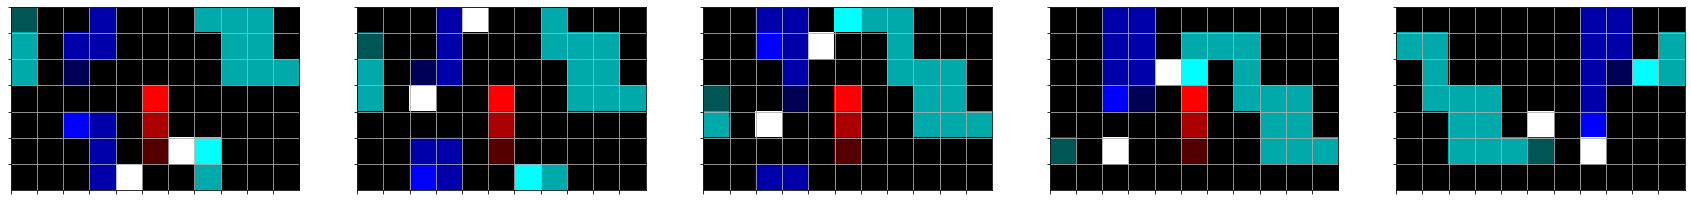

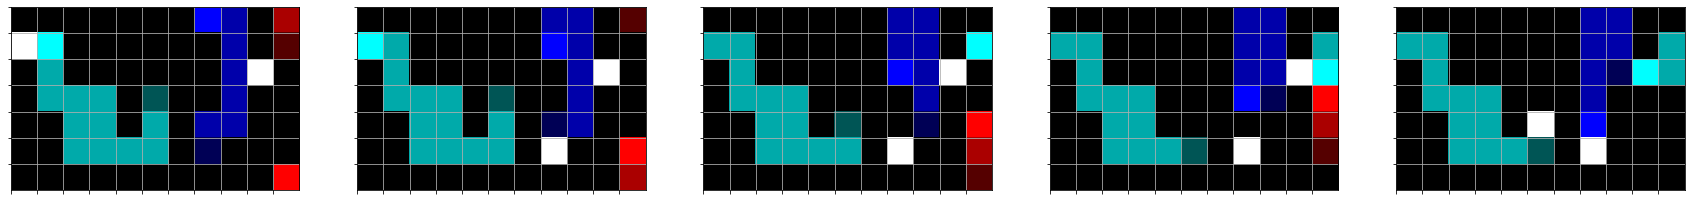

In [7]:
steps = list(range(-5, 0, 1))
for idx, step in enumerate(steps):
    plt.subplot(1, len(steps), idx+1)
    plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
    plt.imshow(state.render_board(state.boards[step]))
plt.show()
for idx, step in enumerate(steps):
    plt.subplot(1, len(steps), idx+1)
    plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
    plt.imshow(non_egocentric_state.render_board(non_egocentric_state.boards[step]))

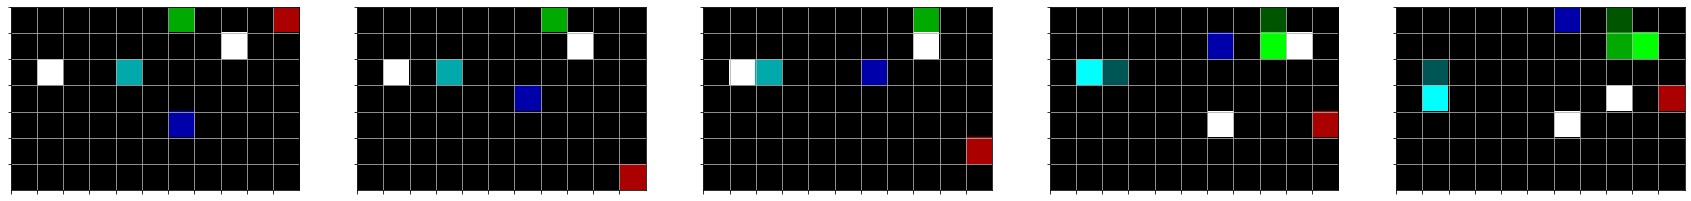

In [9]:
steps = list(range(0, 5))
for idx, step in enumerate(steps):
    plt.subplot(1, len(steps), idx+1)
    plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
    plt.imshow(non_egocentric_state.render_board(non_egocentric_state.boards[step]))

When the goose eats the tail does not move in that turn.

In [27]:
np.array(state.features)[:, 0:-3]

array([[1.   , 1.   , 0.2  , 0.2  , 0.2  , 0.2  ],
       [0.995, 0.975, 0.195, 0.195, 0.195, 0.195],
       [0.99 , 0.95 , 0.19 , 0.19 , 0.19 , 0.19 ],
       [0.985, 0.925, 0.185, 0.185, 0.185, 0.385],
       [0.98 , 0.9  , 0.18 , 0.18 , 0.38 , 0.38 ],
       [0.975, 0.875, 0.175, 0.175, 0.375, 0.375],
       [0.97 , 0.85 , 0.17 , 0.17 , 0.37 , 0.37 ],
       [0.965, 0.825, 0.165, 0.165, 0.365, 0.565],
       [0.96 , 0.8  , 0.16 , 0.16 , 0.36 , 0.56 ],
       [0.955, 0.775, 0.155, 0.155, 0.555, 0.555],
       [0.95 , 0.75 , 0.15 , 0.15 , 0.55 , 0.55 ],
       [0.945, 0.725, 0.145, 0.145, 0.545, 0.545],
       [0.94 , 0.7  , 0.14 , 0.14 , 0.54 , 0.54 ],
       [0.935, 0.675, 0.135, 0.135, 0.535, 0.735],
       [0.93 , 0.65 , 0.13 , 0.13 , 0.53 , 0.73 ],
       [0.925, 0.625, 0.125, 0.125, 0.525, 0.925],
       [0.92 , 0.6  , 0.12 , 0.12 , 0.52 , 0.92 ],
       [0.915, 0.575, 0.115, 0.315, 0.515, 0.915],
       [0.91 , 0.55 , 0.11 , 0.31 , 0.51 , 1.11 ],
       [0.905, 0.525, 0.105, 0.

In [12]:
state.history[-1]

{'remainingOverageTime': 60,
 'step': 9,
 'geese': [[13], [75, 64], [3, 14], []],
 'food': [56, 68],
 'index': 0}

In [11]:
len(state.history)

28

In [13]:
state.history[0]

{'remainingOverageTime': 60,
 'step': 0,
 'geese': [[64], [57], [67], [0]],
 'food': [22, 61],
 'index': 0}

In [12]:
state.configuration

{'episodeSteps': 200,
 'actTimeout': 1,
 'runTimeout': 1200,
 'columns': 11,
 'rows': 7,
 'hunger_rate': 40,
 'min_food': 2,
 'max_length': 99}

## Model

In [4]:
def simple_model():
    board_input = keras.layers.Input((7, 11, 17))
    features_input = keras.layers.Input((9,))
    
    board_encoder = board_input
    for _ in range(3):
        board_encoder = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='valid')(board_encoder)
    board_encoder = keras.layers.Flatten()(board_encoder)
    
    mlp_input = keras.layers.concatenate([board_encoder, features_input])
    output = keras.layers.Dense(16, activation='relu')(mlp_input)
    output = keras.layers.Dense(4, activation='linear')(output)
    
    model = keras.models.Model(inputs=[board_input, features_input], outputs=output)
    return model

In [6]:
model = simple_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 11, 13)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 9, 16)     1888        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 7, 16)     2320        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 5, 16)     2320        conv2d_1[0][0]                   
______________________________________________________________________________________________

In [7]:
model.predict([np.zeros((1, 7, 11, 13), dtype=np.float32), np.zeros((1, 9), dtype=np.float32)])

array([[0., 0., 0., 0.]], dtype=float32)

In [9]:
# cpu
for _ in range(100):
    model.predict([np.zeros((1, 7, 11, 13), dtype=np.float32), np.zeros((1, 9), dtype=np.float32)])

In [9]:
# gpu0
for _ in range(100):
    model.predict([np.zeros((1, 7, 11, 13), dtype=np.float32), np.zeros((1, 9), dtype=np.float32)])

In [15]:
# gpu0
batch_size = 100
model.predict([np.zeros((batch_size, 7, 11, 13), dtype=np.float32), np.zeros((batch_size, 9), dtype=np.float32)], batch_size=batch_size);

In [18]:
# gpu0
batch_size = 1000
model.predict([np.zeros((batch_size, 7, 11, 13), dtype=np.float32), np.zeros((batch_size, 9), dtype=np.float32)], batch_size=batch_size);

In [20]:
# gpu0
batch_size = 10000
model.predict([np.zeros((batch_size, 7, 11, 13), dtype=np.float32), np.zeros((batch_size, 9), dtype=np.float32)], batch_size=batch_size);

On cpu it takes around 20ms to make a prediction.

With tensorboard 2.1 it is very slow to create an to make predictions, I have stopped it after more than 10 minutes of initialization.  
So I'm going to advance to 2.4.1

https://www.reddit.com/r/tensorflow/comments/jbp2sh/tensorflow_with_rtx_3080_extremely_slow/

> I use RTX 3070 and experienced similar issue, but when switched to conda with cudatoolkit 11.0.221, cudnn 8.0.4 and tensorflow-gpu 2.4.1 it initialized model instantly!

- cudatoolkit with conda
- tensorflow with pip
- cudnn copying the files manually: https://stackoverflow.com/questions/55256671/how-to-install-latest-cudnn-to-conda

```bash
tar -xzf cudnn-11.2-linux-x64-v8.1.1.33.tgz
cp cuda/include/cudnn*.h ~/miniconda3/envs/goose/include
cp cuda/lib64/libcudnn* ~/miniconda3/envs/goose/lib
```

We can see that if we want to make single predictions in this case cpu is faster, probably with a bigger model this will be different.
In the other hand when we do batch predictions gpu is way more faster.

## Agent

The agent will have an internal GameState for playing an a model that uses the game state as input to return which action to take.

I'm going to implement it on the library also.

In [5]:
class QValueAgent():
    def __init__(self, model):
        self.model = model
        self.state = GameState()
        self.previous_action = None
    
    def __call__(self, observation, configuration):
        board, features = self.state.update(observation, configuration)
        q_value = self.model.predict([np.expand_dims(board, axis=0), np.expand_dims(features, axis=0)])[0]
        action = ACTIONS[self.select_action(q_value)]
        self.previous_action = action
        self.state.add_action(action)
        return action
        # TODO: how to deal with previous action if epsilon agent is playing, add a method to change previous action
    
    def reset(self):
        self.state.reset()
        self.previous_action = None
        
    def update_previous_action(self, previous_action):
        """ Allows to change previous action if an agent such as epsilon-greedy agent is playing"""
        self.previous_action = previous_action
        self.state.update_last_action(previous_action)
    
    def select_action(self, q_value):
        q_value += np.random.uniform(0, 1e-3, len(q_value))
        if self.previous_action is not None:
            q_value[ACTION_TO_IDX[opposite_action(self.previous_action)]] -= 1e6
        return np.argmax(q_value)

In [6]:
model = simple_model()
agent = QValueAgent(model)

In [37]:
agent.reset()
env = make('hungry_geese', configuration=dict(episodeSteps=200))
trainer = env.train([None, "greedy", "greedy", "greedy"])

configuration = env.configuration

obs = trainer.reset()
done = False
while not done:
    action = agent(obs, configuration)
    obs, reward, done, info = trainer.step(action)
agent(obs, configuration);

In [38]:
np.array(agent.state.boards).shape, np.array(agent.state.features).shape, np.array(agent.state.actions).shape, np.array(agent.state.rewards).shape

((35, 7, 11, 17), (35, 9), (35,), (34,))

In [39]:
rewards = np.array(agent.state.rewards)

In [40]:
rewards

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1])

In [42]:
np.cumsum(rewards[::-1])[::-1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

This is the way to compute the cumulative reward for each state.

## Model for training

In [6]:
def create_model_for_training(model):
    input_mask = keras.layers.Input((4,))
    output = keras.backend.sum(input_mask*model.output, axis=-1)
    new_model = keras.models.Model(inputs=(model.inputs + [input_mask]), outputs=output)
    return new_model

In [48]:
traininig_model = create_model_for_training(model)
traininig_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 11, 17)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 9, 16)     2464        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 7, 16)     2320        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 5, 16)     2320        conv2d_1[0][0]                   
____________________________________________________________________________________________

In [47]:
model.predict([np.ones((1, 7, 11, 17)), np.zeros((1, 9))])

array([[-0.14275733, -0.07466232, -0.26412973, -0.01538348]],
      dtype=float32)

In [50]:
traininig_model.predict([np.ones((4, 7, 11, 17)), np.zeros((4, 9)), np.eye(4)])

array([-0.14275734, -0.07466233, -0.26412973, -0.01538347], dtype=float32)

Seems to be working. So I can use the model for playing and the training_model for training.

## Prepare data for training

I will implement that functionality on the GameState.

In [8]:
model = simple_model()
traininig_model = create_model_for_training(model)
agent = QValueAgent(model)

In [9]:
agent.reset()
env = make('hungry_geese', configuration=dict(episodeSteps=200))
trainer = env.train([None, "greedy", "greedy", "greedy"])
configuration = env.configuration

obs = trainer.reset()
done = False
while not done:
    action = agent(obs, configuration)
    obs, reward, done, info = trainer.step(action)
agent(obs, configuration);

In [24]:
data = agent.state.prepare_data_for_training()
print([element.shape for element in data])

[(27, 7, 11, 17), (27, 9), (27, 4), (27,)]


In [27]:
traininig_model.compile(optimizer='Adam', loss='mean_squared_error')

In [29]:
traininig_model.fit(x=data[:3], y=data[-1], epochs=5)

Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.7556
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 0.6886
Epoch 3/5
1/1 [==============================] - 0s 4ms/step - loss: 0.6231
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 0.5588
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 0.4947


We can use the data for training, so let's continue.

## Simmetry on the data

The board is simmetric and we cannot do anything to solve that, however the order of the other goose is irrelevant. But I cannot think of a representation that is order irrelevant but preserves individual information.

On a first step I will simply apply all simmetries: 2x2x6 = x24

I will visualize the simmetries to verify they are correctly applied.

As input this functions will receive the data for training.

### Vertical and horizontal simmetry

In [7]:
def vertical_simmetry(data):
    boards = data[0][:, ::-1].copy()
    actions = data[2].copy()
    # change north by south and viceversa
    actions[:, 0] = data[2][:, 2]
    actions[:, 2] = data[2][:, 0]
    return boards, data[1], actions, data[-1]

In [8]:
def horizontal_simmetry(data):
    boards = data[0][:, :, ::-1].copy()
    actions = data[2].copy()
    # change west by east and viceversa
    actions[:, 1] = data[2][:, 3]
    actions[:, 3] = data[2][:, 1]
    return boards, data[1], actions, data[-1]

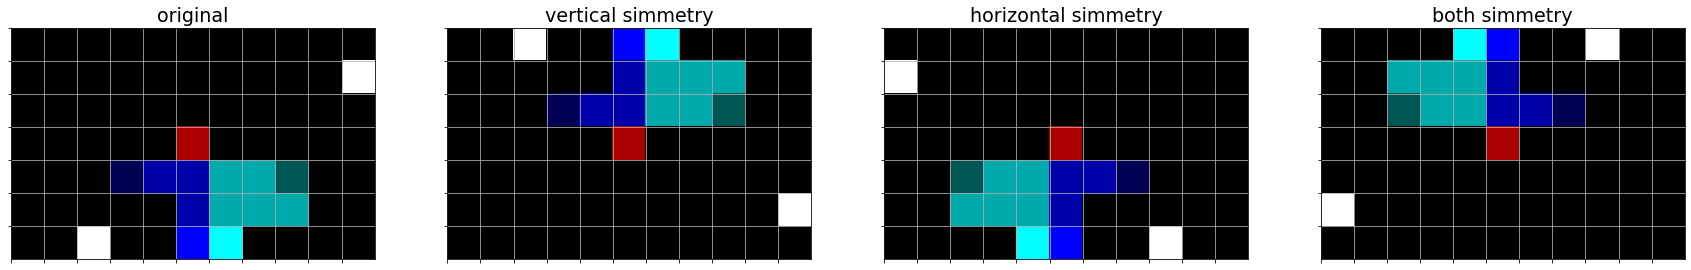

In [41]:
data_vertical = vertical_simmetry(data)
data_horizontal = horizontal_simmetry(data)
data_both = vertical_simmetry(horizontal_simmetry(data))

plt.subplot(1, 4, 1)
plt.title('original')
plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
plt.imshow(agent.state.render_board(data[0][-1]))

plt.subplot(1, 4, 2)
plt.title('vertical simmetry')
plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
plt.imshow(agent.state.render_board(data_vertical[0][-1]))

plt.subplot(1, 4, 3)
plt.title('horizontal simmetry')
plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
plt.imshow(agent.state.render_board(data_horizontal[0][-1]))

plt.subplot(1, 4, 4)
plt.title('both simmetry')
plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
plt.imshow(agent.state.render_board(data_both[0][-1]));

Looks good.

### Player simmetry

On player simmetry we are going to change the position of the other players. So we have to change the board, and also the features because some of them are position dependent.

As input we should probably give the new positions, for example \[2, 0, 1]

In [9]:
def player_simmetry(data, new_positions):
    boards = data[0].copy()
    features = data[1].copy()
    for old_idx, new_idx in enumerate(new_positions):
        boards[:, :, :, 4*(new_idx+1):4*(new_idx+2)] = data[0][:, :, :, 4*(old_idx+1):4*(old_idx+2)]
        features[:, 3+new_idx] = data[1][:, 3+old_idx]
        features[:, 6+new_idx] = data[1][:, 6+old_idx]
    return boards, features, data[2], data[3]

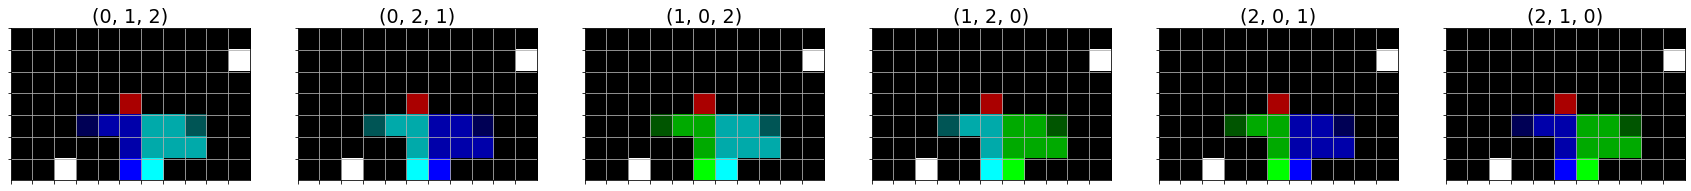

In [62]:
all_permutations = list(permutations([0, 1, 2]))
for idx, new_positions in enumerate(all_permutations):
    new_data = player_simmetry(data, new_positions)
    plt.subplot(1, len(all_permutations), idx+1)
    plt.title(new_positions)
    plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
    plt.imshow(agent.state.render_board(new_data[0][-1]));

### Apply all simmetries

In [10]:
def apply_all_simetries(data):
    all_data = []
    
    data_vertical = vertical_simmetry(data)
    data_horizontal = horizontal_simmetry(data)
    data_both = vertical_simmetry(horizontal_simmetry(data))
    all_permutations = list(permutations([0, 1, 2]))
    for new_positions in all_permutations:
        all_data.append(player_simmetry(data, new_positions))
        all_data.append(player_simmetry(data_vertical, new_positions))
        all_data.append(player_simmetry(data_horizontal, new_positions))
        all_data.append(player_simmetry(data_both, new_positions))
    return combine_data(all_data)

def combine_data(all_data):
    boards = np.concatenate([_data[0] for _data in all_data])
    features = np.concatenate([_data[1] for _data in all_data])
    actions = np.concatenate([_data[2] for _data in all_data])
    rewards = np.concatenate([_data[3] for _data in all_data])
    return boards, features, actions, rewards

In [69]:
all_data = apply_all_simetries(data)
print([element.shape for element in all_data])

[(648, 7, 11, 17), (648, 9), (648, 4), (648,)]


In [67]:
traininig_model.fit(x=all_data[:3], y=all_data[-1], epochs=5)

Epoch 1/5
21/21 [==============================] - 0s 3ms/step - loss: 0.2556
Epoch 2/5
21/21 [==============================] - 0s 3ms/step - loss: 0.1371
Epoch 3/5
21/21 [==============================] - 0s 4ms/step - loss: 0.0843
Epoch 4/5
21/21 [==============================] - 0s 4ms/step - loss: 0.0599
Epoch 5/5
21/21 [==============================] - 0s 4ms/step - loss: 0.0466


It is still working, so we can continue.

## First training

Create the agents

In [11]:
model = simple_model()
training_model = create_model_for_training(model)
training_model.compile(optimizer='Adam', loss='mean_squared_error')
base_agent = QValueAgent(model)
epsilon_agent = EpsilonAgent(base_agent, epsilon=0.1)

Create the environment

In [12]:
env = make('hungry_geese', configuration=dict(episodeSteps=200))
trainer = env.train([None, "greedy", "greedy", "greedy"])
configuration = env.configuration

Train loop 

In [13]:
def log_to_tensorboard(key, value, epoch, tensorboard_writer):
    with tensorboard_writer.as_default():
        tf.summary.scalar(key, value, step=epoch)
        
def get_mean_reward(all_data):
    rewards = [data[3][0] for data in all_data]
    return np.mean(rewards)

def get_mean_steps(all_data):
    steps = [len(data[3]) for data in all_data]
    return np.mean(steps)

In [14]:
def log_epoch_results(all_data, tensorboard_writer, epoch):
    rewards = [data[3][0] for data in all_data]
    print('Reward\tMean: %.2f\tStd: %.2f' % (np.mean(rewards), np.std(rewards)))
    steps = [len(data[3]) for data in all_data]
    print('Steps\tMean: %.2f\tStd: %.2f' % (np.mean(steps), np.std(steps)))
    with tensorboard_writer.as_default():
        tf.summary.scalar('mean_reward', np.mean(rewards), step=epoch)
        tf.summary.scalar('mean_steps', np.mean(steps), step=epoch)

In [15]:
def q_learning_train(name, epochs, episodes_per_epoch, initial_epoch=0):
    tensorboard_writer = tf.summary.create_file_writer('../logs/%s' % name)
    for epoch in tqdm(range(initial_epoch, initial_epoch + epochs), desc='Epochs'):
        agent_data = []
        # play with greedy agent
        for episode in range(episodes_per_epoch//2):
            base_agent.reset()
            obs = trainer.reset()
            done = False
            while not done:
                action = base_agent(obs, configuration)
                obs, reward, done, info = trainer.step(action)
            base_agent(obs, configuration);
            agent_data.append(base_agent.state.prepare_data_for_training())
        log_to_tensorboard('mean_reward', get_mean_reward(agent_data), epoch, tensorboard_writer)
        log_to_tensorboard('mean_steps', get_mean_steps(agent_data), epoch, tensorboard_writer)
        # play with epsilon agent
        epsilon_data = []
        for episode in range(episodes_per_epoch//2):
            epsilon_agent.reset()
            obs = trainer.reset()
            done = False
            while not done:
                action = epsilon_agent(obs, configuration)
                obs, reward, done, info = trainer.step(action)
            epsilon_agent(obs, configuration);
            epsilon_data.append(base_agent.state.prepare_data_for_training())
        log_to_tensorboard('epsilon_mean_reward', get_mean_reward(epsilon_data), epoch, tensorboard_writer)
        log_to_tensorboard('epsilon_mean_steps', get_mean_steps(epsilon_data), epoch, tensorboard_writer)

        all_data = agent_data + epsilon_data
        all_data = combine_data(all_data)
        all_data = apply_all_simetries(all_data)
        ret = training_model.fit(x=all_data[:3], y=all_data[-1], epochs=1, verbose=False)
        log_to_tensorboard('loss', ret.history['loss'][-1], epoch, tensorboard_writer)

In [16]:
name = get_timestamp()
print(name)

2021_03_06_21_36_44


In [17]:
q_learning_train(name, epochs=100, episodes_per_epoch=20)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
q_learning_train(name, epochs=900, episodes_per_epoch=20, initial_epoch=100)

Epochs:   0%|          | 0/900 [00:00<?, ?it/s]

In [20]:
q_learning_train(name, epochs=10000, episodes_per_epoch=20, initial_epoch=1000)

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

After 2500 epochs, 50k episodes and around 1M steps the model does not seem to have learned anything.

I should move this to script so I can run multiple trainings on parallel.

## More information and more tests

To solve the problem I'm going to log more information to tensorboard so I can better diagnose the problem.
I will also do a better parametrization of the train so I can easily make experiments.
And I'm going to write tests to have 100% coverage.

## Test for independent execution of scripts

I want to find if when given a script path as input the modules are independent. Instead of caching the agent each module will have a single agent.

In [9]:
env = make('hungry_geese', debug=True, configuration=dict(episodeSteps=5))
agent_path = '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus_test.py'
ret = env.run([agent_path]*4)

n_calls: 1 [<Action.SOUTH: 3>]
n_calls: 1 [<Action.EAST: 2>]
n_calls: 1 [<Action.EAST: 2>]
n_calls: 1 [<Action.EAST: 2>]
n_calls: 2 [<Action.SOUTH: 3>, <Action.SOUTH: 3>]
n_calls: 2 [<Action.EAST: 2>, <Action.EAST: 2>]
n_calls: 2 [<Action.EAST: 2>, <Action.SOUTH: 3>]
n_calls: 2 [<Action.EAST: 2>, <Action.SOUTH: 3>]
n_calls: 3 [<Action.SOUTH: 3>, <Action.SOUTH: 3>, <Action.EAST: 2>]
n_calls: 3 [<Action.EAST: 2>, <Action.EAST: 2>, <Action.SOUTH: 3>]
n_calls: 3 [<Action.EAST: 2>, <Action.SOUTH: 3>, <Action.WEST: 4>]
n_calls: 3 [<Action.EAST: 2>, <Action.SOUTH: 3>, <Action.SOUTH: 3>]
n_calls: 4 [<Action.SOUTH: 3>, <Action.SOUTH: 3>, <Action.EAST: 2>, <Action.SOUTH: 3>]
n_calls: 4 [<Action.EAST: 2>, <Action.EAST: 2>, <Action.SOUTH: 3>, <Action.WEST: 4>]
n_calls: 4 [<Action.EAST: 2>, <Action.SOUTH: 3>, <Action.WEST: 4>, <Action.NORTH: 1>]
n_calls: 4 [<Action.EAST: 2>, <Action.SOUTH: 3>, <Action.SOUTH: 3>, <Action.EAST: 2>]


This shows that each agent is independent. So we can safely reuse agents without the need for caching.

## Evaluate models

### Data

In [34]:
initial_elo_ranking = pd.read_csv('../data/elo_ranking.csv', index_col='model')
initial_elo_ranking

,ranking
model,
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766
random_plus,706


In [12]:
agents = {
    'random': 'random',
    'random_plus': '../forum/agents/random_plus.py',
    'greedy': 'greedy',
    'risk_averse_goose': '../forum/agents/risk_averse_goose.py',
    'goose_on_a_healthy_diet': '../forum/agents/goose_on_a_healthy_diet.py',
    'straightforward_bfs': '../forum/agents/straightforward_bfs.py',
    'boilergoose': '../forum/agents/boilergoose.py',
    'crazy_goose': '../forum/agents/crazy_goose.py',
    'besthoarder': '../forum/agents/besthoarder.py',
    'greedyhoarder': '../forum/agents/greedyhoarder.py',
    'q_value': '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py',
}

### Play games

In [42]:
reduced_agents_set = {
    'random': 'random',
    'random_plus': '../forum/agents/random_plus.py',
    'greedy': 'greedy',
    'greedyhoarder': '../forum/agents/greedyhoarder.py',
    'q_value': '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py',
}

In [43]:
def sample_agents_func(agents):
    while 1:
        sampled_agents = ['q_value'] + np.random.choice(list(agents), 3).tolist()
        if len(np.unique(sampled_agents)) >=2:
            break
    return sampled_agents

In [44]:
matches_agents, matches_results = play_matches_in_parallel(reduced_agents_set, partial(sample_agents_func, reduced_agents_set))

  0%|          | 0/1000 [00:00<?, ?it/s]

### Compute Elo score

I'm going to compute Elo score while leaving the score of the other agents constant.

In [47]:
initial_ranking = initial_elo_ranking.to_dict()['ranking']
initial_ranking['q_value'] = initial_ranking['random_plus']
initial_ranking = {key: [value] for key, value in initial_ranking.items() if key in reduced_agents_set}
elo_ranking = EloRanking(initial_ranking, {'q_value'}, k=1)

for match_agents, match_results in zip(matches_agents, matches_results):
    elo_ranking.add_match(match_agents, match_results)

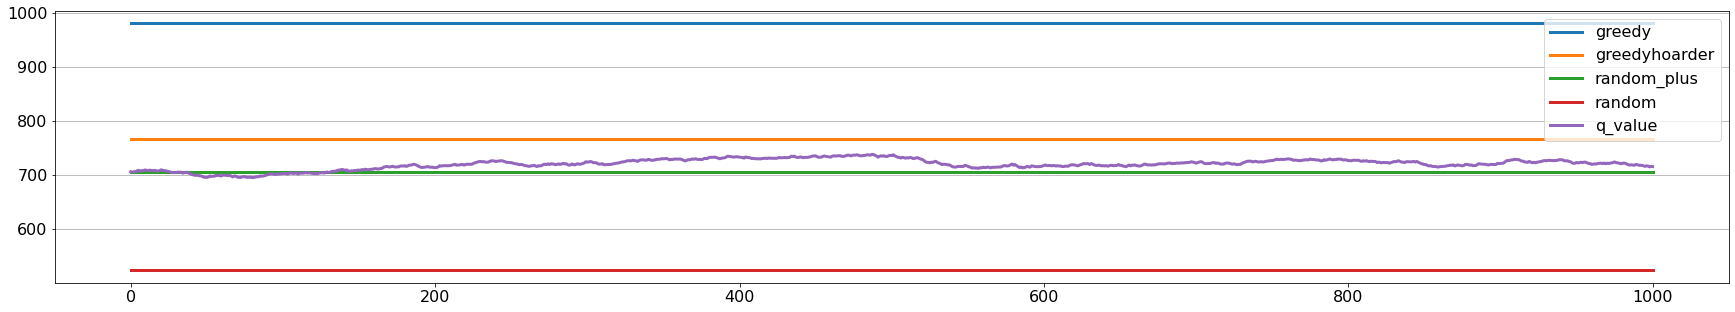

In [48]:
elo_ranking.plot()

In [30]:
elo_ranking.summary()

,ranking
boilergoose,1324
besthoarder,1309
goose_on_a_healthy_diet,1239
risk_averse_goose,1232
crazy_goose,1228
greedy,1041
straightforward_bfs,1036
greedyhoarder,751
random_plus,734
q_value,682


## Visualizing some games

- ¿Can I save the games to video file?
- ¿Can I render the name of the agents?

In [20]:
env = make('hungry_geese', debug=True)
env.run([
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_agent/q_value_agent.py',
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py',
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py',
    '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py',
])[-1]

Goose Collision: SOUTH
Goose Collision: NORTH
Goose Collision: NORTH


[{'action': 'WEST',
  'reward': 10504,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 104,
   'geese': [[43, 33, 44, 54], [], [], []],
   'food': [36, 24],
   'index': 0},
  'status': 'DONE'},
 {'action': 'NORTH',
  'reward': 10402,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 1},
  'status': 'DONE'},
 {'action': 'NORTH',
  'reward': 6201,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 2},
  'status': 'DONE'},
 {'action': 'NORTH',
  'reward': 3601,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 3},
  'status': 'DONE'}]

In [21]:
env.render(mode="ipython")

In [ ]:
/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_agent/q_value_agent.py

## Idea to speedup training

1. Move agent to script, and the agent will load the model
2. Play episodes in parallel and return the history as output
3. On the main thread receive the history, transform it to train data and train on gpu, save the model and repeat

## TODO

- More tests
- Why epsilon agent is much worse?

## Summary